# PLAN
## Initial
#### Safe bet to use Alpha Vantage to develop Model
## Final Step
#### Once ready to do extensive tranning with Multiple Stocks we will need to use SEC EDGAR most likely (need to figure that out) or pay for like a month subscription of Alpha Vantage

In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta


# Using FMP
# - This is more accurate and consitent! Yahoo is web scrapping
# - Provides the financial statetement for a broader range then yahoo finance

# Key which is given from my FMP account. (This key is needed to make requests) Maximum of 200 calls/day
API_KEY = "wUvM2M29ZVxHDvK8IRp2P7iyrT8uhQG4"

ticker = "AAPL"

end_date = datetime(2024, 6, 1)
start_date = end_date - timedelta(days=5000)

url_hist_stock_price = f"https://financialmodelingprep.com/stable/historical-price-eod/light?symbol={ticker}&from={start_date.date()}&to={end_date.date()}&apikey={API_KEY}"

# Historical Data Request
response_hist_stock_price = requests.get(url_hist_stock_price)

json_response_hist_stock_price = response_hist_stock_price.json()


In [2]:
closing_price = pd.DataFrame(json_response_hist_stock_price)

# Convert 'date' to datetime type
closing_price['date'] = pd.to_datetime(closing_price['date'])

# Keep only 'date' and 'price' columns
closing_price = closing_price[['date', 'price']]

closing_price['price'] = pd.to_numeric(closing_price['price'], errors='coerce')
closing_price['date'] = pd.to_datetime(closing_price['date'], errors='coerce')
# Set 'date' as the index
closing_price.set_index('date', inplace=True)

print(closing_price)

             price
date              
2024-05-31  192.25
2024-05-30  191.29
2024-05-29  190.29
2024-05-28  189.99
2024-05-24  189.98
...            ...
2010-09-29   10.26
2010-09-28   10.24
2010-09-27   10.40
2010-09-24   10.44
2010-09-23   10.32

[3445 rows x 1 columns]


In [3]:
# ALPHA VANTAGE EXPERIMENTING (https://www.alphavantage.co/documentation/#)
# gives some insight into the different attributes without sending demo request: https://documentation.alphavantage.co/FundamentalDataDocs/gaap_documentation.html

API_KEY = "FJLURMBXQEXWW9PP"

ticker = "AAPL"

def getInfo(function:str,ticker:str):
    url = f"https://www.alphavantage.co/query?function={function.upper()}&symbol={ticker}&apikey={API_KEY}"
    response = requests.get(url)
    return response.json()

In [4]:
# Requests
r_income_statements = getInfo("income_statement",ticker)
r_balance_sheet = getInfo("balance_sheet",ticker)
r_cash_flow = getInfo("cash_flow",ticker)

In [6]:
# Dataframes
df_income_statement = pd.DataFrame(r_income_statements["quarterlyReports"])
df_income_statement['fiscalDateEnding'] = pd.to_datetime(df_income_statement['fiscalDateEnding'])

#df_income_statement = df_income_statement.rename(columns={"fiscalDateEnding": "dates"})
df_income_statement.set_index("fiscalDateEnding", inplace=True)
df_income_statement = df_income_statement.apply(pd.to_numeric, errors='coerce')
df_income_statement = df_income_statement.fillna(0)



df_balance_sheet = pd.DataFrame(r_balance_sheet["quarterlyReports"])
df_balance_sheet['fiscalDateEnding'] = pd.to_datetime(df_balance_sheet['fiscalDateEnding'])
#df_balance_sheet = df_balance_sheet.rename(columns={"fiscalDateEnding": "dates"})
df_balance_sheet.set_index("fiscalDateEnding", inplace=True)
df_balance_sheet = df_balance_sheet.apply(pd.to_numeric, errors='coerce')
df_balance_sheet = df_balance_sheet.fillna(0)


df_cash_flow = pd.DataFrame(r_cash_flow["quarterlyReports"])
df_cash_flow['fiscalDateEnding'] = pd.to_datetime(df_cash_flow['fiscalDateEnding'])
#df_cash_flow = df_cash_flow.rename(columns={"fiscalDateEnding": "dates"})
df_cash_flow.set_index("fiscalDateEnding", inplace=True)
df_cash_flow = df_cash_flow.apply(pd.to_numeric, errors='coerce')
df_cash_flow = df_cash_flow.fillna(0)


In [6]:
# Available data
#print("Income Statement\n",df_income_statement.columns)
#print("Balance Sheet\n",df_balance_sheet.columns)
#print("Cash Flow\n",df_cash_flow.columns)

In [7]:
# TODO: Adjust all metrics such that they can be mapped to that of closing price (i.e the dates)
import numpy as np
# Often used terms
net_income = df_income_statement['netIncome']
equity = df_balance_sheet["totalShareholderEquity"]
outstandingShares = df_balance_sheet["commonStockSharesOutstanding"]
book_value = equity
book_value_per_share = book_value/outstandingShares
total_revenue =df_income_statement['totalRevenue']

# Profitability Metrics
EPS = (net_income-df_cash_flow["dividendPayoutPreferredStock"])/outstandingShares
#ROE = net_income/equity
net_Profit_Margin = net_income/total_revenue

# Valuation Metrics--> MOST PROBLEMATIC HERE
#P_E_Ratio = closing_price/EPS
#P_B_Ratio = closing_price/book_value_per_share
#P_S_Ratio = closing_price*outstandingShares/total_revenue

# Risk and Efficiency metrics
D_E_Ratio = np.log(df_balance_sheet["shortLongTermDebtTotal"]/equity)
Current_Ratio = df_balance_sheet["totalCurrentAssets"]/df_balance_sheet["totalCurrentLiabilities"]



/home/frank-lucas/Repos/portfolio-optimizer/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


               price    ret_1d    ret_5d   ret_10d    vol_5d   vol_10d  \
date                                                                     
2024-03-21  1.863021 -0.259451  0.073870  0.324988 -0.205296 -0.715008   
2024-03-20  1.990617  2.438933  0.906237  1.219372  0.860089  0.042581   
2024-03-19  1.945347 -0.778720  1.080453  0.836759  0.682598  0.191722   
2024-03-18  1.904096 -0.717122  0.533703  0.668357  0.887638  0.273293   
2024-03-15  1.884870 -0.318622  0.142819  0.412519  0.904786  0.292747   
...              ...       ...       ...       ...       ...       ...   
2010-10-06 -0.951780  0.038234 -0.868458 -1.155069 -0.928781  0.084554   
2010-10-05 -0.951955 -0.016323 -0.750185 -1.108902 -0.861531  0.094237   
2010-10-04 -0.958422 -1.982326 -1.408752 -2.195404 -0.006862 -0.243281   
2010-10-01 -0.955975  0.831200 -0.938779 -1.787303  0.403960  0.055589   
2010-09-30 -0.955276  0.261652 -0.419707 -1.033552  0.394575 -0.301342   

            momentum_10d  sma_ratio_1

array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'ret_1d'}>,
        <Axes: title={'center': 'ret_5d'}>],
       [<Axes: title={'center': 'ret_10d'}>,
        <Axes: title={'center': 'vol_5d'}>,
        <Axes: title={'center': 'vol_10d'}>],
       [<Axes: title={'center': 'momentum_10d'}>,
        <Axes: title={'center': 'sma_ratio_10_50'}>,
        <Axes: title={'center': 'zscore_20d'}>],
       [<Axes: title={'center': 'rsi_14'}>,
        <Axes: title={'center': 'y'}>, <Axes: >]], dtype=object)

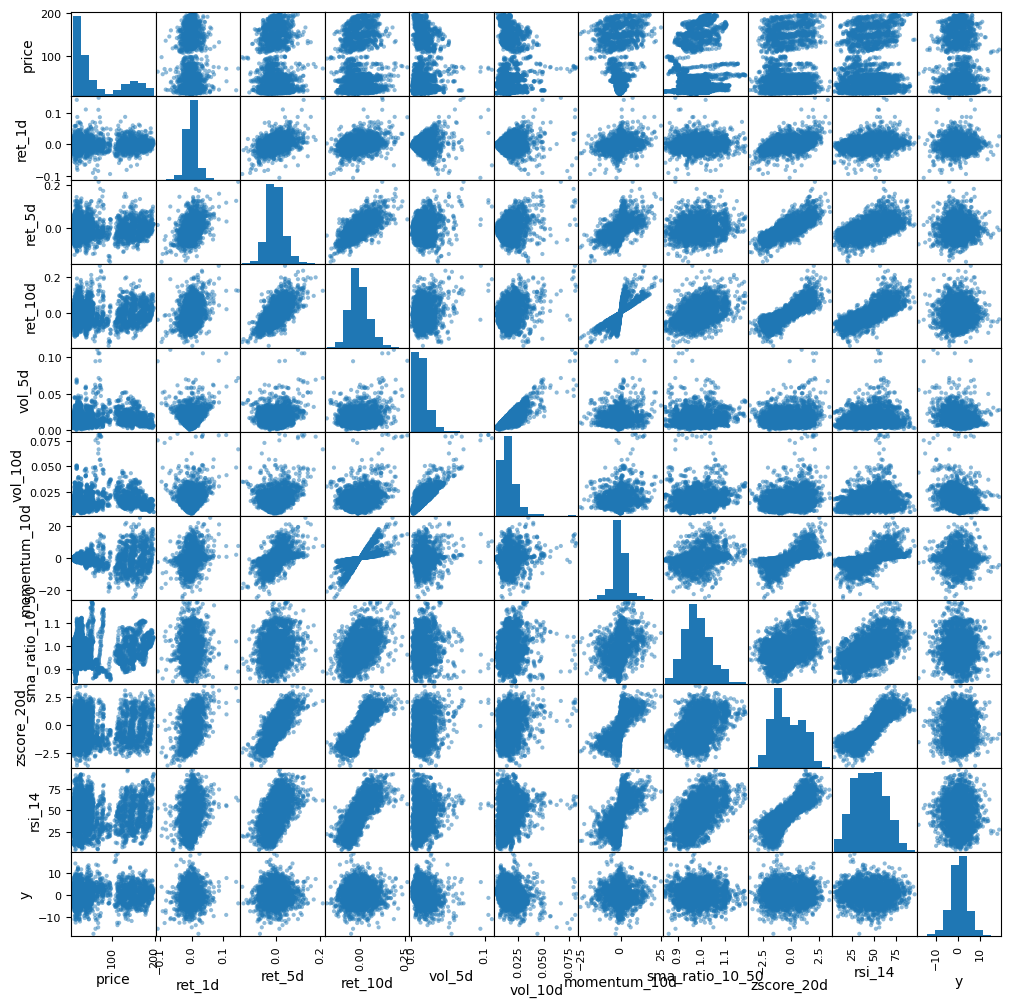

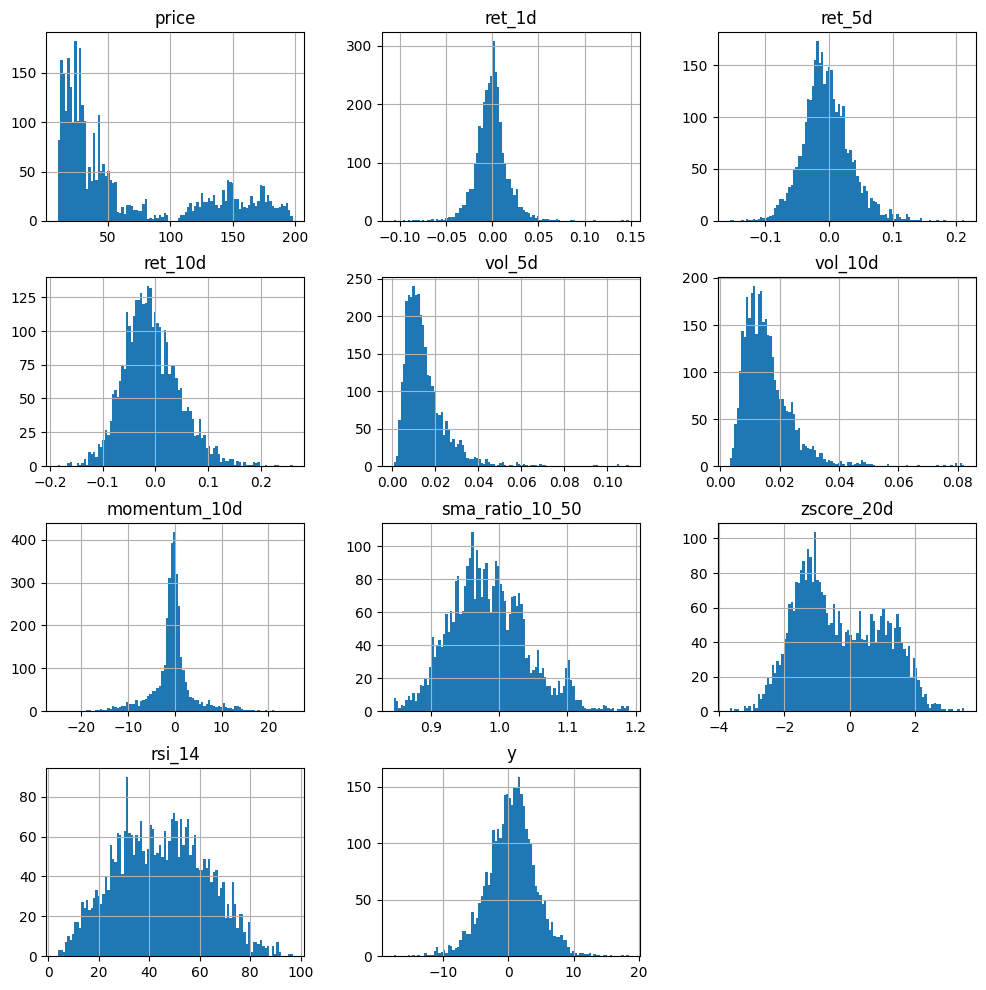

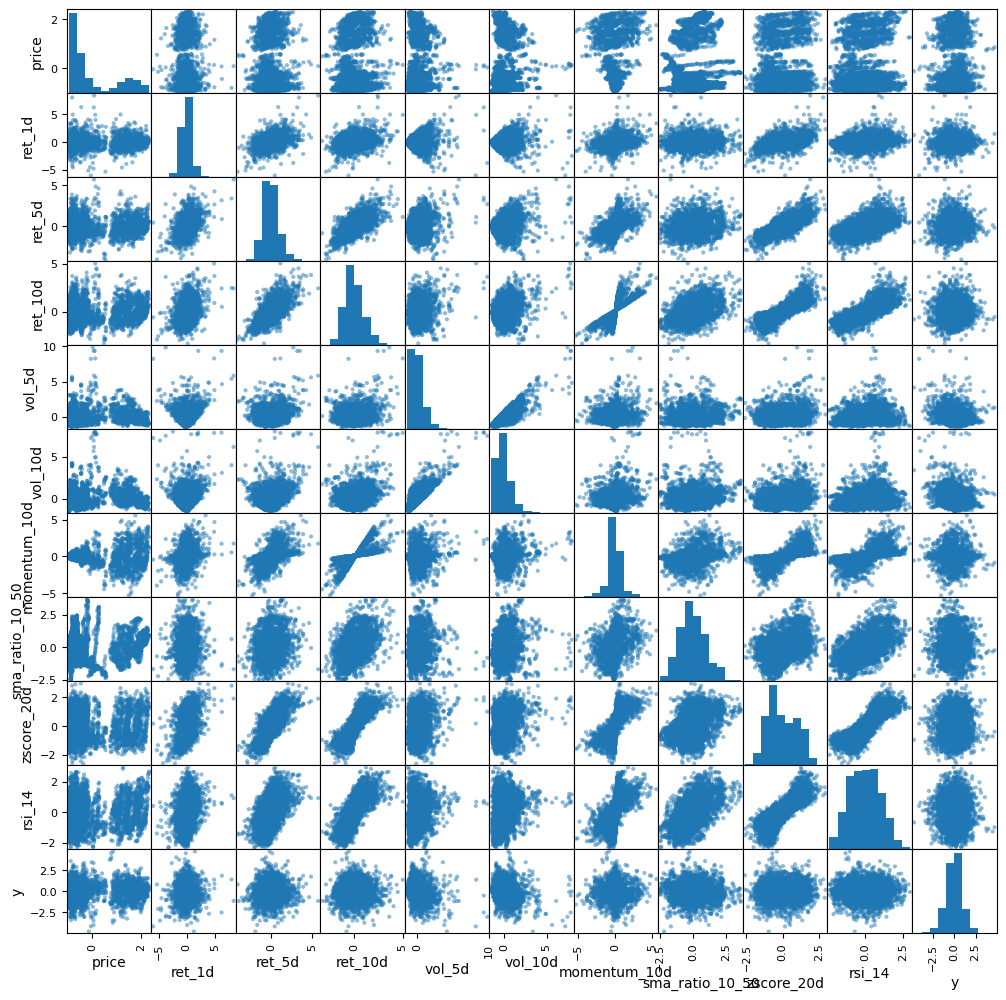

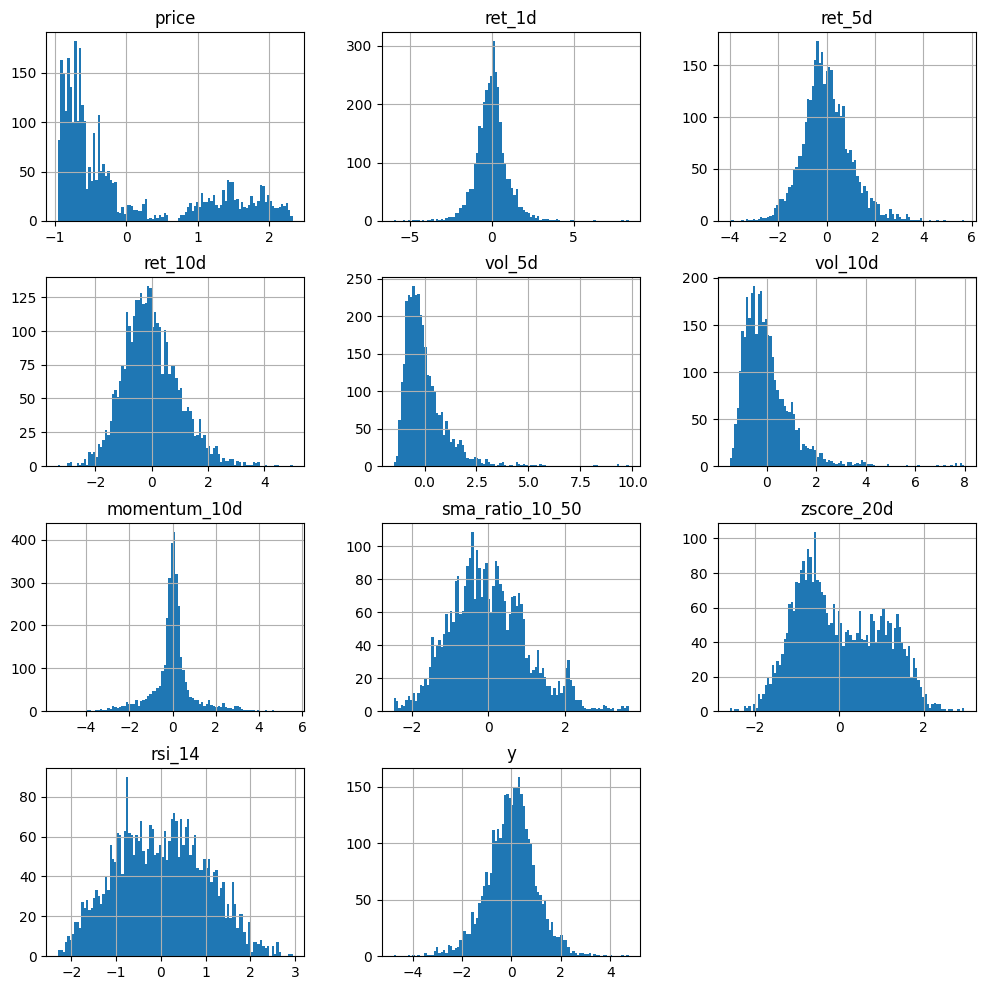

In [ ]:
# INITIAL FEATURES

import pandas as pd
import numpy as np

columns_part1 = []
# Daily Return
daily_return = closing_price.pct_change()

# 5-Day Return
ret_5d = closing_price.pct_change(5)
# 10-Day Return
ret_10d = closing_price.pct_change(10)

# 5-Day Volatility (Std Dev of Returns)
vol_5d = closing_price.pct_change().rolling(window=5).std()

# 10-Day Volatility
vol_10d = (closing_price.pct_change().rolling(window=10).std())

# Momentum (10d)
momentum_10d = closing_price - closing_price.shift(10)

# SMA_10/SMA_50 Ratio
sma_10 = closing_price.rolling(window=10).mean()
sma_50 = closing_price.rolling(window=50).mean()
sma_ratio = sma_10/sma_50

# Z-score (20d)
rolling_mean = closing_price.rolling(window=20).mean()
rolling_std = closing_price.rolling(window=20).std()
z_score_20d = (closing_price - rolling_mean)/rolling_std

# RSI (14d)
delta = closing_price.diff()
gain = delta.where(delta > 0, 0.0)
loss = -delta.where(delta < 0, 0.0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain/avg_loss
rsi_14 = 100 - (100 / (1 + rs))
y =  closing_price.pct_change(-5)*100
y.columns = ['y']

dataframes = [
    (closing_price,'price'),
    (daily_return, 'ret_1d'),
    (ret_5d, 'ret_5d'),
    (ret_10d, 'ret_10d'),
    (vol_5d, 'vol_5d'),
    (vol_10d, 'vol_10d'),
    (momentum_10d, 'momentum_10d'),
    (sma_ratio, 'sma_ratio_10_50'),
    #(z_score_20d, 'zscore_20d'),
    (rsi_14, 'rsi_14'),
    (y,'y')
]

df_features_short_term = pd.concat(
    [df.rename(columns={df.columns[0]: name}) for df, name in dataframes],
    axis=1
).dropna()

from pandas.plotting import scatter_matrix

scatter_matrix(df_features_short_term, figsize=(12, 12), diagonal='hist')  # or 'kde'
df_features_short_term.hist(figsize=(12, 12), bins=100)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_features_short_term)
X_scaled = scaler.transform(df_features_short_term)
df_scaled = pd.DataFrame(X_scaled, index=df_features_short_term.index, columns=df_features_short_term.columns)
print(df_scaled)
from pandas.plotting import scatter_matrix

scatter_matrix(df_scaled, figsize=(12, 12), diagonal='hist')  # or 'kde'
df_scaled.hist(figsize=(12, 12), bins=100)



,price,ret_1d,ret_5d,ret_10d,vol_5d,vol_10d,momentum_10d,sma_ratio_10_50,zscore_20d,rsi_14,y
price,1.000000,0.012286,0.029840,0.009369,0.139736,0.159990,-0.198976,-0.047077,0.005568,0.026560,0.002234
ret_1d,0.012286,1.000000,0.377122,0.220292,0.104540,0.089740,0.169070,-0.013778,0.372575,0.178710,-0.063859
ret_5d,0.029840,0.377122,1.000000,0.610843,0.090135,0.155544,0.450415,0.059268,0.714702,0.449540,-0.049482
ret_10d,0.009369,0.220292,0.610843,1.000000,0.025414,0.129044,0.716573,0.316247,0.822918,0.741007,-0.012764
vol_5d,0.139736,0.104540,0.090135,0.025414,1.000000,0.698076,-0.004911,0.035311,0.106372,0.130291,-0.130994
vol_10d,0.159990,0.089740,0.155544,0.129044,0.698076,1.000000,0.059272,0.093750,0.206481,0.206636,-0.153343
momentum_10d,-0.198976,0.169070,0.450415,0.716573,-0.004911,0.059272,1.000000,0.279278,0.615252,0.545948,-0.052102
sma_ratio_10_50,-0.047077,-0.013778,0.059268,0.316247,0.035311,0.093750,0.279278,1.000000,0.365518,0.512608,0.028900
zscore_20d,0.005568,0.372575,0.714702,0.822918,0.106372,0.206481,0.615252,0.365518,1.000000,0.813753,-0.042009
rsi_14,0.026560,0.178710,0.449540,0.741007,0.130291,0.206636,0.545948,0.512608,0.813753,1.000000,-0.019498


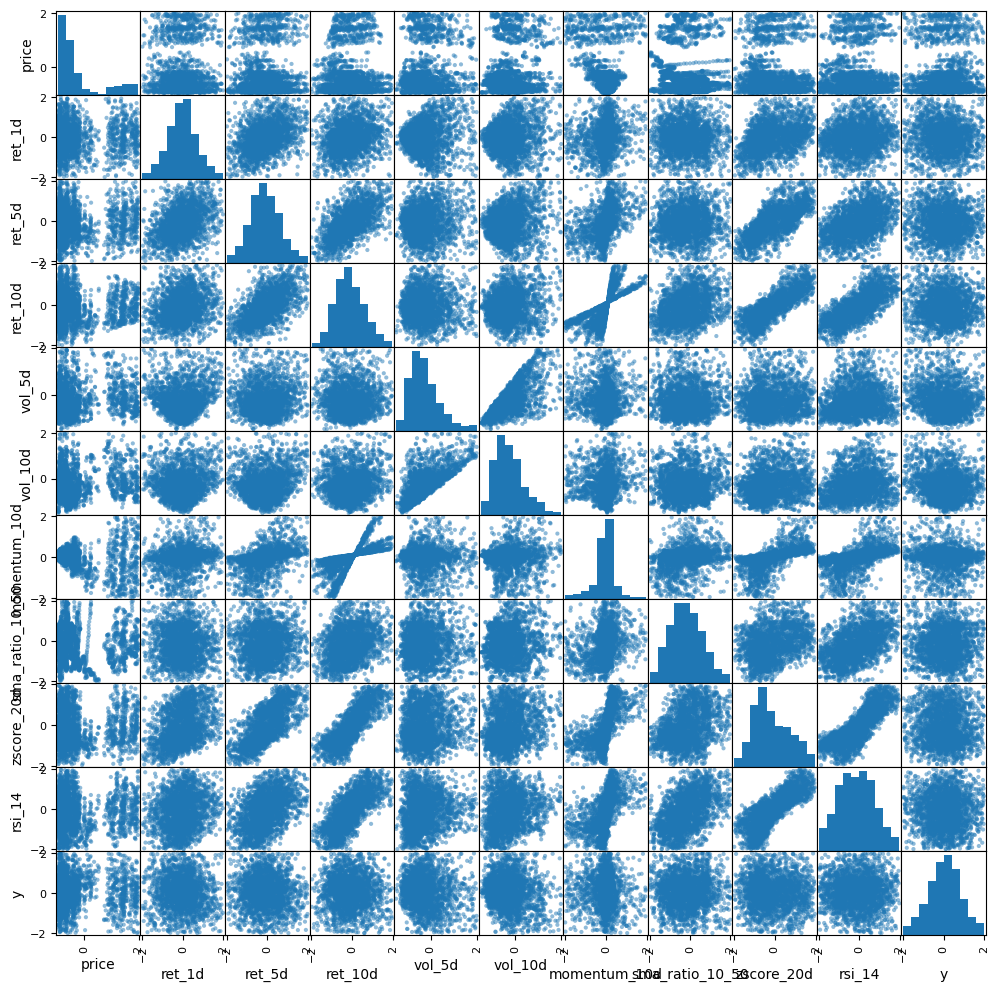

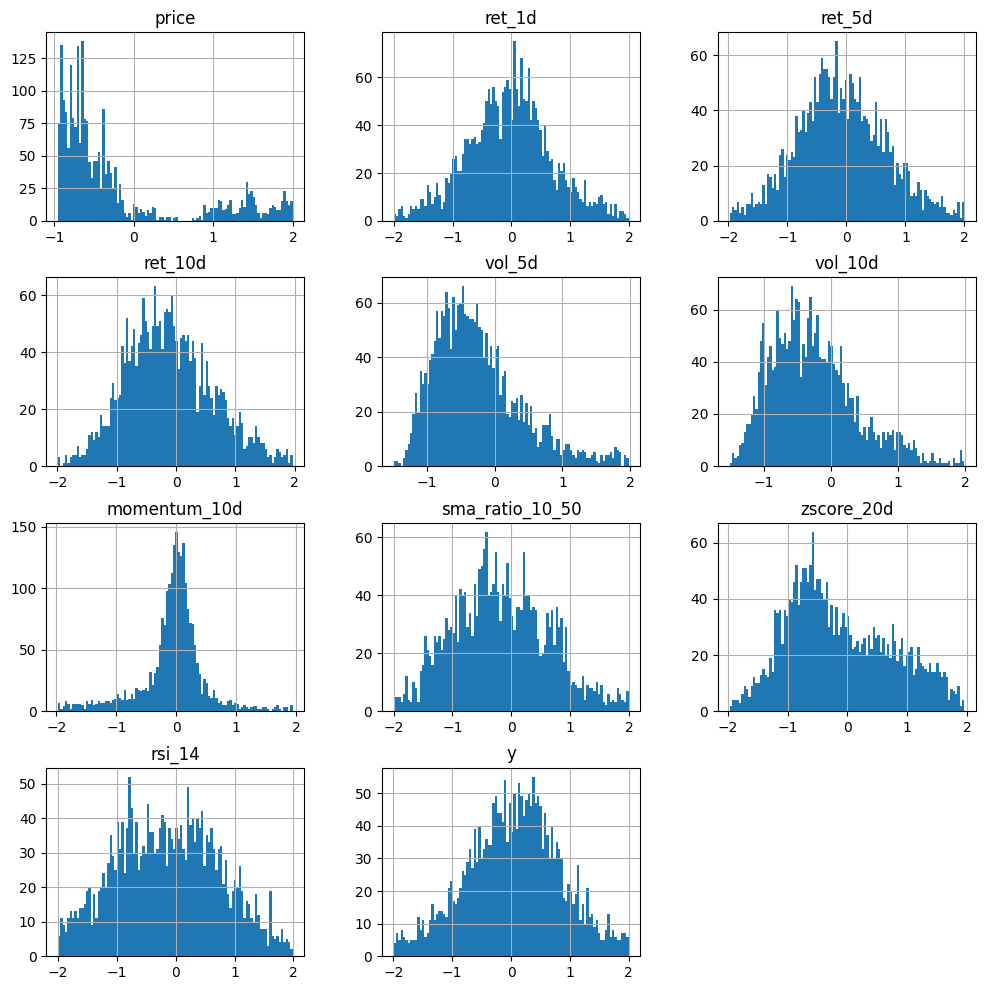

In [9]:
import numpy as np
import pandas as pd
from scipy.stats import zscore

# Calculate Z-scores for the dataset
z_scores = np.abs(zscore(df_scaled))

# Set a threshold for identifying outliers (commonly 3)
threshold = 2 # confidence interval of data around 97.6 %.

# Identify rows where any column has a Z-score greater than threshold
outliers = (z_scores > threshold).any(axis=1)

# Remove outliers
df_no_outliers = df_scaled[~outliers]


# DATA ANALYSIS

from pandas.plotting import scatter_matrix

scatter_matrix(df_no_outliers, figsize=(12, 12), diagonal='hist')  # or 'kde'
df_no_outliers.hist(figsize=(12, 12), bins=100)

df_no_outliers.corr()


In [9]:

#print(df_balance_sheet.columns)

outstandingShares_str = df_balance_sheet["commonStockSharesOutstanding"]
outstandingShares = outstandingShares_str.apply(pd.to_numeric, errors='coerce')
df_metrics = pd.DataFrame()

df_features_long_term = pd.concat([
    EPS.rename('EPS'),
    #ROE.rename('ROE'),
    #D_E_Ratio.rename('D_E_Ratio'),
    #Current_Ratio.rename('Current_Ratio')

], axis=1)


combined_rows = []
quarter_dates = df_features_long_term.index
pos = 0

columns = ['date']
columns.extend(df_features_short_term.columns.to_list())
columns.extend(df_features_long_term.columns.to_list())
#columns.extend(['P_E_ratio','P_B_ratio'])
#columns.extend(['P_E_ratio','P_B_ratio','P_S_ratio'])

for date,row in df_features_short_term.iterrows():
    index = quarter_dates[pos]
    if (pos < len(quarter_dates)):
        if index < date:
            new_row = [date]
            new_row.extend(row.to_list())
            new_row.extend(df_features_long_term.loc[index].to_list())

            bv_per_share_elem = book_value_per_share.loc[index]
            outstandingShares_elem = outstandingShares.loc[index]
            total_revenue_elem = total_revenue.loc[index]
            
            #P_E_ratio = row.price/df_features_long_term.loc[index]['EPS']
            #P_B_ratio = row.price/bv_per_share_elem
            #P_S_ratio = row.price*outstandingShares_elem/total_revenue_elem

            #new_row.extend([P_E_ratio,P_B_ratio,P_S_ratio])
            #new_row.extend([P_E_ratio,P_B_ratio])


            combined_rows.append(new_row)
        else:
            pos+=1
df_features = pd.DataFrame(combined_rows,columns=columns)
print(df_features.columns)
df_features = df_features.dropna()
df_features=df_features.drop(columns=['price'])

df_features.set_index('date',inplace=True)
print(df_features.columns)

  # NEED TO COMBINE THE ROWS TOGHETHER INTO!



Index(['date', 'price', 'ret_1d', 'ret_5d', 'ret_10d', 'vol_5d', 'vol_10d',
       'momentum_10d', 'sma_ratio_10_50', 'rsi_14', 'y', 'EPS'],
      dtype='object')
Index(['ret_1d', 'ret_5d', 'ret_10d', 'vol_5d', 'vol_10d', 'momentum_10d',
       'sma_ratio_10_50', 'rsi_14', 'y', 'EPS'],
      dtype='object')


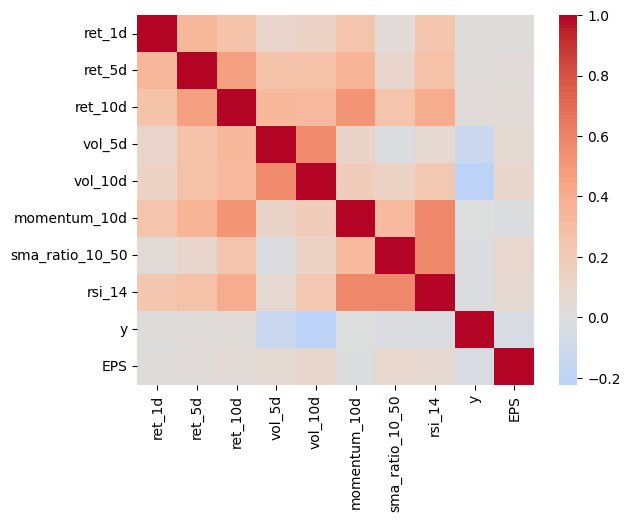

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df_features.corr(), cmap="coolwarm", center=0)
plt.show()

In [ ]:
# Train
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

# Features df
X = df_no_outliers.drop(columns=['y'])
print(X.columns)
# Target Columns
y = df_no_outliers['y']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Train a Linear Regression model (least squared)
model = LinearRegression()
model.fit(X_train, y_train) # Find A in y=Ax
print(model.score(X_test, y_test))

# Predict and evaluate
y_pred = model.predict(X_test) # Predict y_test using the A matrix found and X_test
mse = root_mean_squared_error(y_test,y_pred) # Compare the found y_test (y_prep) to the true y_test


Index(['price', 'ret_1d', 'ret_5d', 'ret_10d', 'vol_5d', 'vol_10d',
       'momentum_10d', 'sma_ratio_10_50', 'rsi_14'],
      dtype='object')
0.043840243328628126
date
2010-10-27   -0.367644
2015-05-19    0.752561
2018-08-20    0.705830
2019-01-28   -0.216943
2014-11-14    1.131616
                ...   
2020-04-23   -1.202483
2015-06-01   -0.536065
2010-11-19   -0.249453
2011-12-14   -0.737795
2012-08-15    0.336274
Name: y, Length: 486, dtype: float64 [ 0.1041197   0.13291796  0.2794724  -0.29176947  0.03828258  0.09038304
  0.07312868  0.00893229 -0.16526289 -0.10789774  0.18329052  0.10870842
  0.18354609 -0.01280569  0.02416803  0.12687841  0.14079895  0.10042015
 -0.00178401  0.17862346  0.12656806  0.03635179  0.12210806  0.08244601
 -0.47589584  0.09865451  0.15359356  0.1422425  -0.19445024  0.15846891
 -0.23705964  0.18735536  0.10405802 -0.34532046 -0.17445986 -0.10093386
  0.13127592  0.10101485  0.05136944  0.02674525  0.15041951  0.08008275
  0.15833248 -0.20310639  0.16

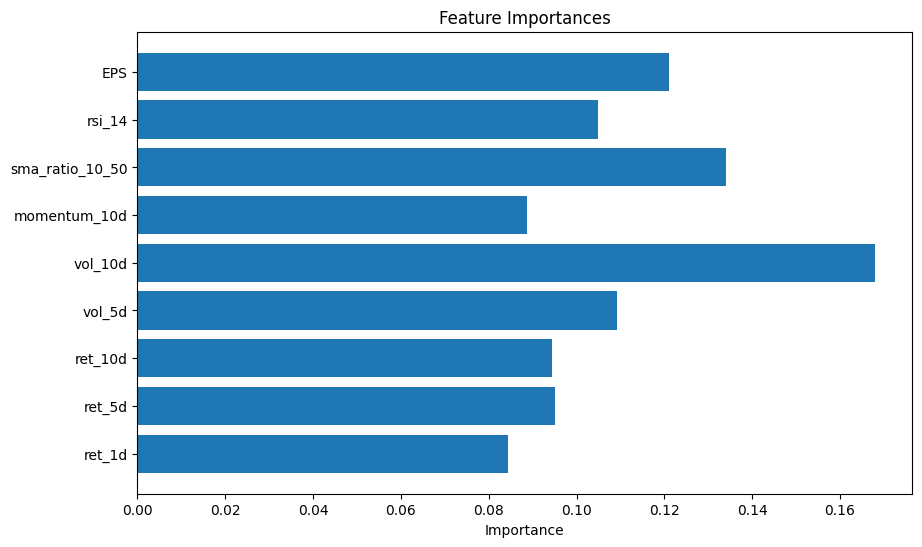

1.050449667322648


In [12]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
rf = RandomForestRegressor(random_state=42,n_estimators=400)
#X_mod = pd.DataFrame()
#X_mod = X_train[['vol_10d','ret_1d','ret_5d','vol_5d']]
#X_mod_test = X_test[['vol_10d','ret_1d','ret_5d','vol_5d']]
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

importances = rf.feature_importances_
feature_names = X_train.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()


mse = mean_squared_error(y_test,y_pred)
q1 = y.quantile(0.25)
q3 = y.quantile(0.75)
iqr = q3 - q1
nRMSE = (mse*(1/2)) / iqr

print(nRMSE) # <0.5 excellent, 0.5-1.0 good, 1.0-1.5 moderate, >1.5 Weak

In [13]:
result = pd.DataFrame()
result['y'] = y_test
result['y_pred'] = y_pred
print(result)

q1 = y.quantile(0.25)
q3 = y.quantile(0.75)
iqr = q3 - q1
nRMSE = (mse*(1/2)) / iqr
print(nRMSE) 

print('Mean Squared Error', mse)
print('Min of y:', q1)
print('Max of y:', q3)
print('error',nRMSE)

                    y    y_pred
date                           
2022-12-01  -1.826968  0.142191
2011-09-20   7.496361  3.444508
2021-04-15   3.175821  1.682456
2018-10-30  -4.220546 -1.949880
2017-11-16  -2.706391  0.095068
...               ...       ...
2011-02-01   1.066448  0.647305
2018-03-02   0.387420  1.551732
2018-05-04  13.257762  0.770628
2012-06-13   0.097991  0.557891
2014-04-11  -2.264350 -1.096093

[668 rows x 2 columns]
1.050449667322648
Mean Squared Error 9.528570829163671
Min of y: -1.77711958533876
Max of y: 2.7583527583527667
error 1.050449667322648


In [32]:
import xgboost as xgb
import shap


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


# Set up parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # Regression problem
    'max_depth': 6,                   # Depth of the tree
    'eta': 0.1,                       # Learning rate
    'subsample': 0.8,                 # Fraction of samples used for training
    'colsample_bytree': 0.8,          # Fraction of features used for training
    'eval_metric': 'rmse'             # Evaluation metric (Root Mean Squared Error)
}

# Train the model
num_round = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_round)

#explainer = shap.Explainer(model)
#shap_values = explainer(X_train)
#shap.summary_plot(shap_values, X_train)
#shap.plots.bar(shap_values)


In [15]:
analysis = pd.DataFrame()
epsilon = 1e-8  # to avoid divide-by-zero
analysis['y_true']=y_test
analysis['y_pred']=y_pred

analysis['relative_error'] = np.where(
    np.abs(analysis['y_true']) > 0.01,
    np.abs(analysis['y_true'] - analysis['y_pred']) / np.abs(analysis['y_true']),
    np.nan
)
mean_relative_error = analysis['relative_error'].mean(skipna=True)
print("Mean Relative Error:", mean_relative_error)



print(model.get_score())


Mean Relative Error: 1.3009748142755952
{'ret_1d': 644.0, 'ret_5d': 573.0, 'ret_10d': 550.0, 'vol_5d': 497.0, 'vol_10d': 555.0, 'momentum_10d': 357.0, 'sma_ratio_10_50': 599.0, 'rsi_14': 438.0, 'EPS': 567.0}


In [16]:
y_pred = model.predict(dtest)

# Convert predictions to a DataFrame to see the results
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predictions)

               Actual  Predicted
date                            
2022-12-01  -1.826968   1.641363
2011-09-20   7.496361   3.933366
2021-04-15   3.175821   1.833987
2018-10-30  -4.220546  -3.296940
2017-11-16  -2.706391  -0.340050
...               ...        ...
2011-02-01   1.066448  -1.066010
2018-03-02   0.387420   1.496278
2018-05-04  13.257762   0.800452
2012-06-13   0.097991   0.509432
2014-04-11  -2.264350  -0.585083

[668 rows x 2 columns]


In [17]:
result = pd.DataFrame()
result['y'] = y_test
result['y_pred'] = y_pred
print(result)

q1 = y.quantile(0.25)
q3 = y.quantile(0.75)
iqr = q3 - q1
nRMSE = (mse*(1/2)) / iqr
print(nRMSE) 

print('Mean Squared Error', mse)
print('Min of y:', q1)
print('Max of y:', q3)
print('error',nRMSE)

                    y    y_pred
date                           
2022-12-01  -1.826968  1.641363
2011-09-20   7.496361  3.933366
2021-04-15   3.175821  1.833987
2018-10-30  -4.220546 -3.296940
2017-11-16  -2.706391 -0.340050
...               ...       ...
2011-02-01   1.066448 -1.066010
2018-03-02   0.387420  1.496278
2018-05-04  13.257762  0.800452
2012-06-13   0.097991  0.509432
2014-04-11  -2.264350 -0.585083

[668 rows x 2 columns]
1.050449667322648
Mean Squared Error 9.528570829163671
Min of y: -1.77711958533876
Max of y: 2.7583527583527667
error 1.050449667322648
